---
# FASNet: Face Anti-Spoofing Network
---

From: https://github.com/OeslleLucena/FASNet

A FASNet é uma rede treinada para detecção de ataques spoofing em faces. Essa arquitetura foi baseada na arquitetura da CNN VGG-16, tereinada no ImageNet, alterando-se as últimas camadas totalmente conectadas. No seu treinamento foi realizado um fine-tuning a partir do terceiro bloco.

Organização dos dados nas pastas:

```
dados/
    treino/
        real/ 
            001.jpg
            002.jpg
            ...
        ataque/
            001.jpg
            002.jpg
            ...
    validação/
        real/
            001.jpg
            002.jpg
            ...
        ataque/
            001.jpg
            002.jpg
            ...
```

Arquitetura da VGG-16
![](https://blog.keras.io/img/imgclf/vgg16_original.png)


In [27]:
from __future__ import print_function
import numpy as np
np.random.seed(1337)  # Para Reprodutibilidade
import os
os.environ['THEANO_FLAGS'] = "device=gpu0,floatX=float32"    
import theano

# Módulos a serem utilizados

In [28]:
%matplotlib inline
import matplotlib.pyplot as plt 
import time
import h5py
import numpy as np
from keras.preprocessing.image import ImageDataGenerator,load_img,img_to_array
from keras import optimizers
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import callbacks
from keras import backend as K
from keras.preprocessing.image import load_img,img_to_array
import glob
from sklearn.metrics import confusion_matrix

K.set_image_dim_ordering('th')

# Treinando a FASNet

## Configurações básicas (Caminho, tamanho das entradas, etc)

In [29]:
# Caminho pesos da VGG-16
weights_path = '/home/adessowiki/Development/Oeslle/NUAADatabase/vgg16_weights.h5'

# Caminho para os pesos da FASNet
top_model_weights_path = 'FASNetFtWeights18.h5'

# Dimensão das imagens de entrada
img_width, img_height = 96, 96

# Número de camadas em que os pesos ficaram inalterados (congelados) durante o fine-tuning
nFreeze = 18

# Caminho para a pasta de treino
train_data_dir = '/home/adessowiki/Development/Oeslle/REPLAY-FULL-aligned-images/train'

# Caminho para a pasta de validação
validation_data_dir = '/home/adessowiki/Development/Oeslle/REPLAY-FULL-aligned-images/val'

# Número de amostras no treino
nb_train_samples = (8470 + 26539)

# Número de amostras na validação
nb_validation_samples = (2118 + 6635)

# Número de épocas
nb_epoch = 50

## Funções a serem utilizados no treinamento

In [24]:
# Carrega o modelo da VGG-16 com seus devidos pesos sem as camadas totalmente conectadas
def get_tr_vgg_model(weights_path, img_width, img_height):
    
    model = Sequential()
    model.add(ZeroPadding2D((1, 1), input_shape=(3, img_width, img_height)))

    model.add(Convolution2D(64, 3, 3, activation='relu', name='conv1_1'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(64, 3, 3, activation='relu', name='conv1_2'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(128, 3, 3, activation='relu', name='conv2_1'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(128, 3, 3, activation='relu', name='conv2_2'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(256, 3, 3, activation='relu', name='conv3_1'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(256, 3, 3, activation='relu', name='conv3_2'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(256, 3, 3, activation='relu', name='conv3_3'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, 3, 3, activation='relu', name='conv4_1'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, 3, 3, activation='relu', name='conv4_2'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, 3, 3, activation='relu', name='conv4_3'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, 3, 3, activation='relu', name='conv5_1'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, 3, 3, activation='relu', name='conv5_2'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, 3, 3, activation='relu', name='conv5_3'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    # Carrega os pesos necesários até o último bloco da VGG-15 anterior as camadas densas
    assert os.path.exists(weights_path), 'Model weights not found (see "weights_path" variable in script).'
    f = h5py.File(weights_path)
    for k in range(f.attrs['nb_layers']):
        if k >= len(model.layers):
            break
        g = f['layer_{}'.format(k)]
        weights = [g['param_{}'.format(p)] for p in range(g.attrs['nb_params'])]
        model.layers[k].set_weights(weights)
    f.close()
    print ('Model loaded.')
    
    return model

# Adiciona novas camadas totalmente conecetadas as quais serão utilizadas no fine-tuning
def add_top_layers(model):

    top_model = Sequential()
    top_model.add(Flatten(input_shape=model.output_shape[1:]))
    top_model.add(Dense(256, activation='relu'))
    top_model.add(Dropout(0.5))
    top_model.add(Dense(1, activation='sigmoid'))

    model.add(top_model)
    
    return model

# Executa o treino
def run_train(model):
    
    start_time = time.time()
    
    # Congela as camadas até o terceiro bloco da VGG-16
    for layer in model.layers[:nFreeze]:
        layer.trainable = False

    # Compila o modelo
    model.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=1e-6),
              metrics=['accuracy'])
    
    print ('Model compiled.')
        
    # Aumento de dados para evitar overfitting
    train_datagen = ImageDataGenerator(
            rescale=1./255,
            rotation_range=40,
            width_shift_range=0.2,
            height_shift_range=0.2,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True,
            vertical_flip = True,
            fill_mode='nearest')

    test_datagen = ImageDataGenerator(rescale=1./255)

    # Leitura dos dados pelo diretório
    train_generator = train_datagen.flow_from_directory(
            train_data_dir,
            target_size=(img_height, img_width),
            batch_size=100,
            class_mode='binary')

    validation_generator = test_datagen.flow_from_directory(
            validation_data_dir,
            target_size=(img_height, img_width),
            batch_size=100,
            class_mode='binary')
    

    print ('\nFine-tuning top layers...\n')

    # Early Stopping usado caso o valor da acurácia de validação não mude em 10 épocas
    earlyStopping = callbacks.EarlyStopping(monitor='val_acc',
                                           patience=10, 
                                           verbose=0, mode='auto')

    # Fit no modelo
    history = model.fit_generator(
           train_generator,
           callbacks=[earlyStopping],
           samples_per_epoch=nb_train_samples,
           nb_epoch=nb_epoch,
           validation_data=validation_generator,
    nb_val_samples=nb_validation_samples)

    model.save_weights(top_model_weights_path)
    
    print ('\nDone fine-tuning, have a nice day!')
    print("\nExecution time %s seconds" % (time.time() - start_time))
    
    return history

def plot_curves(history):
    
    # Histórico da acurácia
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('Acurácia')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    
    #  Histórico do loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Erro')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

In [10]:
if __name__ == "__main__":
   
    vgg16_tr_model = get_tr_vgg_model(weights_path, img_width, img_height)
    vgg16_tr_model = add_top_layers(vgg16_tr_model)
    
    # Fine-tuning no modelo 
    history = run_train(vgg16_tr_model)
    


Model loaded.
Model compiled.
Found 35011 images belonging to 2 classes.
Found 8758 images belonging to 2 classes.

Fine-tuning top layers...

Epoch 1/50
35011/35009 [==============================] - 505s - loss: 0.0870 - acc: 0.9644 - val_loss: 0.0011 - val_acc: 0.9999
Epoch 2/50
35011/35009 [==============================] - 503s - loss: 0.0206 - acc: 0.9927 - val_loss: 9.0434e-04 - val_acc: 0.9998
Epoch 3/50
35011/35009 [==============================] - 503s - loss: 0.0078 - acc: 0.9974 - val_loss: 3.9284e-04 - val_acc: 0.9998
Epoch 4/50
35011/35009 [==============================] - 503s - loss: 0.0103 - acc: 0.9968 - val_loss: 0.0051 - val_acc: 0.9982
Epoch 5/50
35011/35009 [==============================] - 503s - loss: 0.0079 - acc: 0.9973 - val_loss: 8.6603e-05 - val_acc: 1.0000
Epoch 6/50
35011/35009 [==============================] - 503s - loss: 0.0091 - acc: 0.9969 - val_loss: 7.3287e-05 - val_acc: 1.0000
Epoch 7/50
35011/35009 [==============================] - 503s - lo

/home/adessowiki/Virtualenvs/theano/local/lib/python2.7/site-packages/keras/engine/training.py:1462: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


## Curvas de Aprendizado

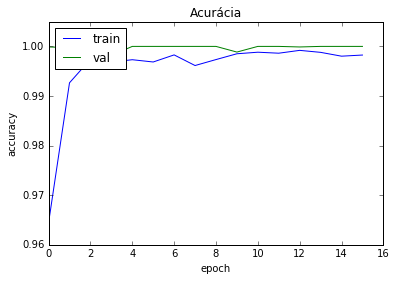

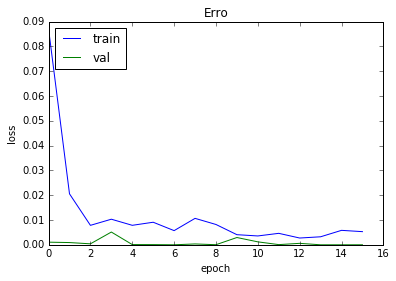

In [25]:
plot_curves(history)

# Test

In [30]:
def load_model(weightsPath,img_width,img_height):
    
    #VGG-16 model
    model = Sequential()
   
    model.add(ZeroPadding2D((1, 1), input_shape=(3, img_width, img_height)))
    model.add(Convolution2D(64, 3, 3, activation='relu', name='conv1_1'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(64, 3, 3, activation='relu', name='conv1_2'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(128, 3, 3, activation='relu', name='conv2_1'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(128, 3, 3, activation='relu', name='conv2_2'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(256, 3, 3, activation='relu', name='conv3_1'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(256, 3, 3, activation='relu', name='conv3_2'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(256, 3, 3, activation='relu', name='conv3_3'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, 3, 3, activation='relu', name='conv4_1'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, 3, 3, activation='relu', name='conv4_2'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, 3, 3, activation='relu', name='conv4_3'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, 3, 3, activation='relu', name='conv5_1'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, 3, 3, activation='relu', name='conv5_2'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, 3, 3, activation='relu', name='conv5_3'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
    
    # Top-model for anti-spoofing
    top_model = Sequential()
    top_model.add(Flatten(input_shape=model.output_shape[1:]))
    top_model.add(Dense(256, activation='relu'))
    top_model.add(Dropout(0.5))
    top_model.add(Dense(1, activation='sigmoid'))
    #
    
    model.add(top_model)
    
    if weightsPath:
        model.load_weights(weightsPath)
    else:
        print ('Could not load model!')
    
    return model

def read_preprocess_image(imgPath,img_width,img_height):
      
    img = load_img(imgPath,target_size=(img_width,img_height))
    imgArray = img_to_array(img)
    imgArray = imgArray.reshape(1,3,img_width, img_height)
    imgArray = imgArray/float(255)
    
    return imgArray

## Predição para uma imagem

In [34]:
if __name__ == "__main__":
    
    # Carregamento dos parâmetros
    imgPath = '/home/adessowiki/Development/Oeslle/REPLAY-FULL-aligned-images/test/Class0/client009_session01_webcam_authenticate_adverse_1.mov001.png'
   
    # Leitura e pré-processamento da imagem
    img = read_preprocess_image(imgPath,img_width,img_height)

    # Carregamento dos pesos
    model = load_model(top_model_weights_path,img_width,img_height)

    # Predição da Classe
    opt = optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=1e-6)
    model.compile(loss='binary_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

    outLabel = int(model.predict_classes(img,verbose=0))
    print ("Label", outLabel)
   
    

Label 0


## Predição e Estatística para todo o dataset de teste

In [38]:
if __name__ == "__main__":

    start_time = time.time()
    
    # Diretório com as imagens de teste
    testDataDir = '/home/adessowiki/Development/Oeslle/REPLAY-FULL-aligned-images/test'
    
    # Carregamento dos pesos
    model = load_model(top_model_weights_path,img_width,img_height)

    testNames = np.array([])
    true = np.asarray(glob.glob(os.path.join(testDataDir, 'Class0/*.png'))) # Class0 igual a real
    fake = np.asarray(glob.glob(os.path.join(testDataDir, 'Class1/*.png'))) # Class1 igual a ataques
    testNames = np.append(true,fake)

    # Predições
    predictions = np.array([])

    for im in testNames:
        img = load_img(im,target_size=(img_width,img_height))
        imgArray = img_to_array(img)
        imgArray = imgArray.reshape(1,3,img_width, img_height)
        imgArray = imgArray/float(255) 
        predictions = np.append(predictions,model.predict_classes(imgArray,batch_size = 50,verbose=0))

    np.save(open('predictionsFT18REPLAY.npy', 'w'), predictions)

    # Gerando os rótulos verdadeiros
    testLabels = np.array([0] * (true.shape[0]) + [1] * (fake.shape[0]))
    
    # Matriz de confusão
    cMat = confusion_matrix(testLabels, predictions)
    FNR = float(cMat[1][0])/(cMat[1][1] + cMat[1][0])
    FPR = float(cMat[0][1])/(cMat[0][0] + cMat[0][1])
    HTER = (FPR + FNR)/2

    print ("Conf. Mat :", cMat)
    print ("ACC =", float(cMat[0,0] + cMat[1,1])/(cMat[0,0] + cMat[1,1] + cMat[1,0] + cMat[0,1]) )
    print ("HTER = %f" % HTER)

    print ('Done!')
    print("\nExecution time %s seconds" % (time.time() - start_time))

Conf. Mat : [[12822   562]
 [   45 41795]]
ACC = 0.989008402144
HTER = 0.021533
Done!

Execution time 1783.63743591 seconds
